
# Apple Quality 데이터 분석 실습

우리는 종종 “이 사과는 좋아 보인다”, “이 사과는 별로다” 라는 판단을 
아주 빠르게 내립니다.

그 판단은 과연 무엇에 근거하고 있을까요?
이번 실습에서는 Kaggle의 Apple Quality 데이터셋을 활용해 사과의 여러 특성을 바탕으로 이 사과가 ’좋은 품질’일 확률을 설명하는 모델을 만들어 보는 것 입니다.

이 과제의 목표는 정확하게 맞히는 것이 아니라, “왜 이 사과가 좋은 사과일 가능성이 높은지”를 숫자와 말로 설명하는 것에 있습니다.

※ 본 과제는 팀/개인 단위 모두 수행 가능합니다

#### 라이브러리 참조

In [4]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas.api.types import CategoricalDtype
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
import pingouin as pg

# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor


from statannotations.Annotator import Annotator

# 로지스틱을 위한 참조
import statsmodels.api as sm

from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt


# 로지스틱 결과 판별을 위한 참조
# → 머신러닝 라이브러리를 미리 사용
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)



# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova


# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell



import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

### 데이터 불러오기

In [5]:
origin = load_data('apple_quality')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/kaggle/apple_quality.xlsx
[desc] 이 데이터 세트는 다양한 과일 속성에 대한 정보를 담고 있어 과일의 특성을 파악하는 데 도움이 됩니다. 데이터 세트에는 과일 ID, 크기, 무게, 당도, 아삭함, 과즙량, 숙성도, 산도 및 품질과 같은 세부 정보가 포함되어 있습니다. (출처: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality)

field        description
-----------  ----------------------------------
A_id         각 과일에 대한 고유 식별자
Size         크기
Weight       무게
Sweetness    단맛 정도
Crunchiness  과일의 아삭한 식감을 나타내는 질감
Juiciness    과일의 과즙 함량 정도
Ripeness     과일이 익은 정도
Acidity      과일의 산도 수준
Quality      과일의 전반적인 품질


==== 데이터 크기 확인 ====
데이터셋 크기: (4000, 9)
열 개수: 9
행 개수: 4000

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchine

### 1단계. 데이터와 첫 인상
1. 데이터의 전체 구조 확인
   - 관측치 수 총 4000개
   - 변수 9 개 (Quality 범주형 외 모두 연속형)

2. 분석 전 중요해보이는 변수 예측
   - 평소 개인 경험 상 Sweetness, Ripeness 가 Quality  에 가장 영향을 많이 주고 있을 것으로 예상된다

In [6]:
origin.tail()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3995,3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,bad
3996,3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,good
3997,3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,bad
3998,3998,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,good
3999,3999,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796,good


In [7]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB


### 2단계. 목표 변수 시각화 - 우리가 맞히려는 대상은 어떤 분포를 가지고 있을까?

1. Quanlity  의 분포를막대그래프로 시각화하자
2. 좋은 사과와 그렇지 않은 사과의 비율을 확인하자
  - good   : 50.1 %  | bad :  49.9%
3. 이 분포를 보고 정확도 하나만으로 모델을 평가해도 괜찮을지 고민해보자
  -  분류 문제에서 good를 bad로 예측한 경우는 False Positive,bad를 good으로 예측한 경우는 False Negative에 해당한다.두 오류 모두 비용을 발생시키지만,False Negative는 불량품이 정상으로 분류되어 시장에 유통될 수 있다는 점에서 더 높은 위험과 손실을 야기한다. 그럼에도 불구하고 정확도는 두 오류를 동일한 오분류로 처리하여 오류 유형 간의 비용 차이를 반영하지 않는다. 이러한 특성으로 인해 정확도는 오류의 중요도가 비대칭적인 실제 문제에서 단독 평가 지표로 사용하기에 한계가 있다.

- Quality 변수의 데이터 타입을 범주형으로 바꿔주자

In [8]:
origin_타입변환 = origin.copy()
origin_타입변환['Quality']=origin_타입변환['Quality'].astype('category')
origin_타입변환['A_id']=origin_타입변환['A_id'].astype(str)
origin_타입변환.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   A_id         4000 non-null   object  
 1   Size         4000 non-null   float64 
 2   Weight       4000 non-null   float64 
 3   Sweetness    4000 non-null   float64 
 4   Crunchiness  4000 non-null   float64 
 5   Juiciness    4000 non-null   float64 
 6   Ripeness     4000 non-null   float64 
 7   Acidity      4000 non-null   float64 
 8   Quality      4000 non-null   category
dtypes: category(1), float64(7), object(1)
memory usage: 254.2+ KB


C:\Users\itwill\AppData\Local\Temp\ipykernel_1664\80181120.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(


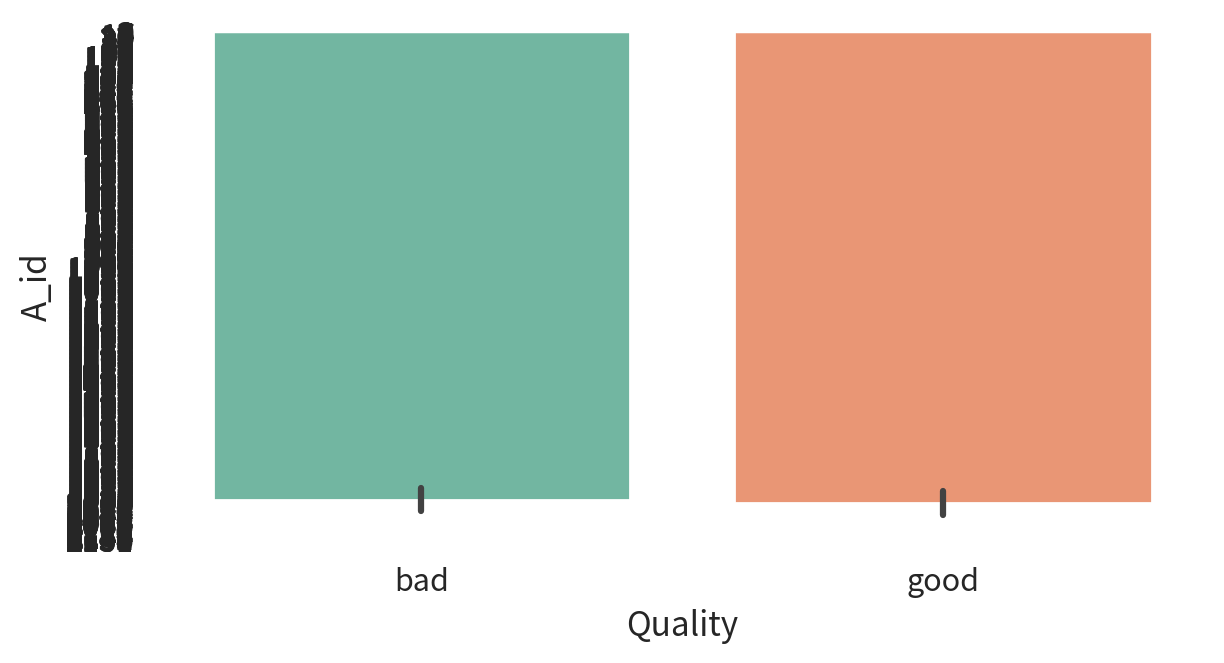

In [9]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) barplot 그리기
sb.barplot(
    data=origin_타입변환,          #사용할 데이터 프레임
    x='Quality',          #막대의 카테고리축
    y='A_id',      #요약할 수치 변수  

    palette ='Set2'
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


In [10]:
#좋은 사과와 그렇지 않은 살과의 비율을 확인해보자

origin_타입변환['Quality'].value_counts()
origin_타입변환['Quality'].value_counts(normalize=True) * 100


Quality
good    50.1
bad     49.9
Name: proportion, dtype: float64

> 현재 Quality  가 good 은 2004개 , bad 은 1996 개로 각각 50.1% ,49,9% 다. 즉 거의 1:1
> ??정확도 하나만으로 모델을 평가하면 안되는 이유??
>
> good 가 bad 로 판정되면 False Positive, Bad 가 Good 으로 판전되면 False Negative 입니다. 전차 역시 손해를 보겠지만, 후자의 경우 불량품이 출하되어 훨씬 치명적이게 됩니다. 정확도의 경우 이 FP ,FN 을 차이 없이 같은 틀린 것으로 인식합니다. 하지만 실제 세계에서는 중요한 오류와 비교적 덜 중요한 오류를 구분해야하는 경우가 있어 정확도 지표 하나만으로는 모델을 평가하기에 부적절합니다. 

### 3단계.단변량 EDA - 사과 하나만 놓고 보았을 떄 무엇이 보이는가?
1. 히스토그램과 KDE 를 그려 분포를 확인하자
   
2. 왜도가 있는 변수가 찾아보자
   - 대부분의 연속형 변수가 정규분포의 형태를 띄고 있는 것으로 확인했다
   - Crunchiness는 전반적으로 대칭에 가깝지만, 약한 음의 왜도가 관찰된다
  
3. 눈에 띄는 이상치가 있는지 시각적으로 판단하자
   - 히스토그램 및 KDE를 통해 분포의 꼬리 부분을 확인한 결과 일부 변수에서 분포의 양 끝단에 위치한 관측치가 존재하나 극단적으로 분리된 값이나 뚜렷한 이상치는 시각적으로 관찰되지 않았다
   - 다만, Z-score 기준(|z| > 3)으로는 모든 변수에서 일정 수의 이상치가 탐지되었다.

C:\Users\itwill\AppData\Local\Temp\ipykernel_1664\4091643620.py:30: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


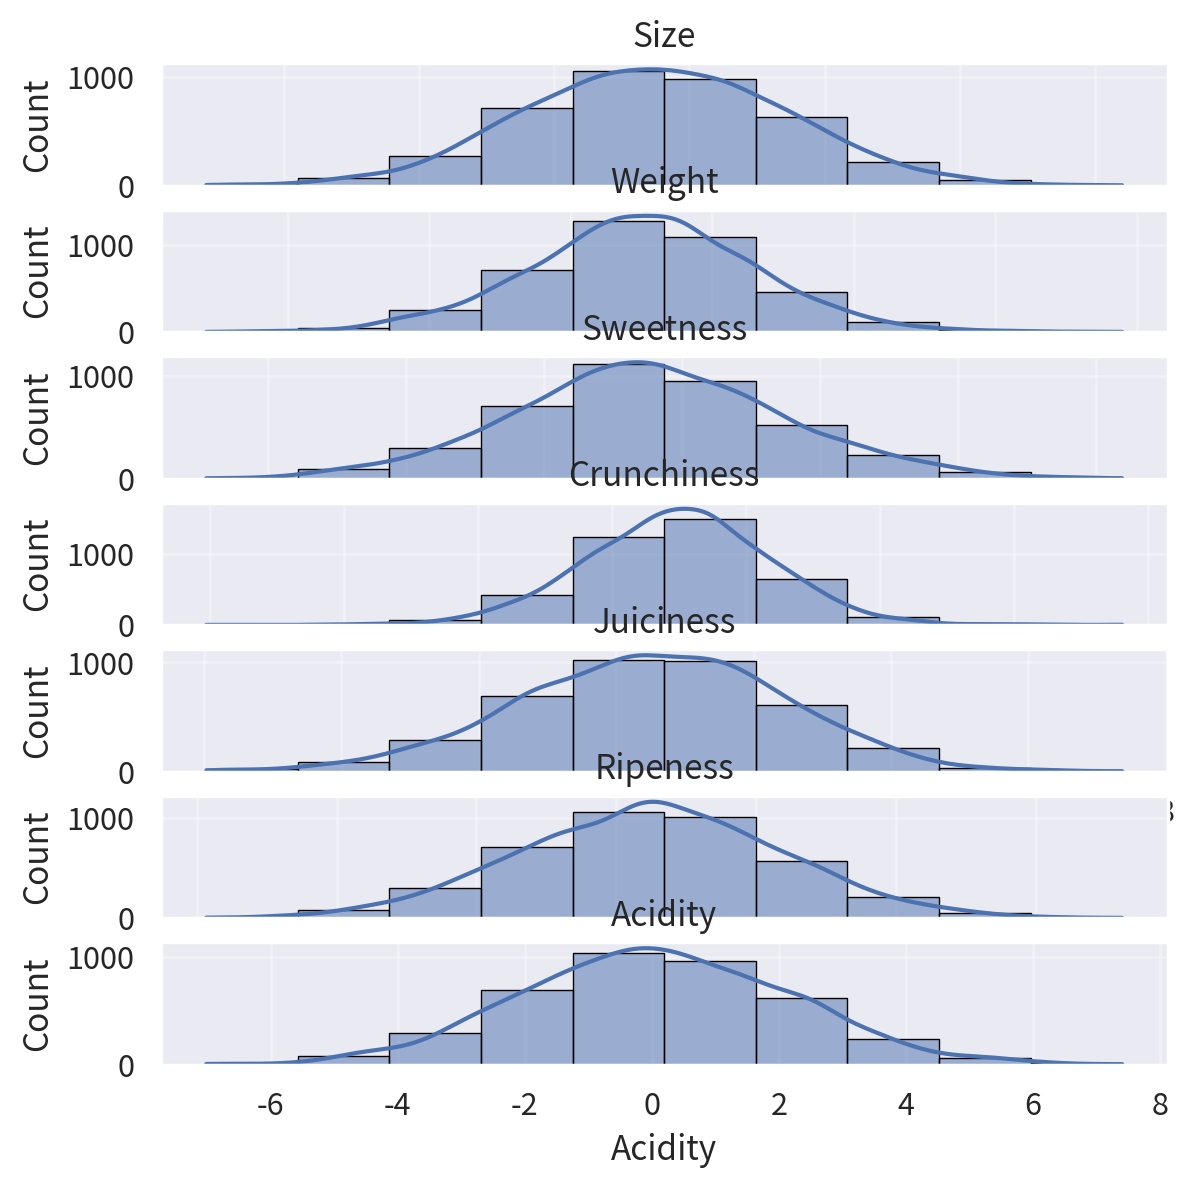

In [11]:
# 히스토그램으로 보고 싶은 컬럼 7개
cols_list = ["Size", "Weight", "Sweetness", "Crunchiness",
             "Juiciness", "Ripeness", "Acidity"]

# 1) 그래프 초기화

width_px = 1300
height_px = 1300
rows = 7
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Histogram 그리기
for i, col in enumerate(cols_list):
    sb.histplot(
        data=origin_타입변환,
        x=col,
        bins=10,
        kde=True,
        edgecolor="#000000",
        linewidth=0.5,
        ax=ax[i]              # ⭐ 핵심
    )
    ax[i].set_title(col)
    ax[i].grid(alpha=0.3)

# 3) 출력
plt.tight_layout()
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()
plt.close()


In [12]:
# 이상치와 왜도 검정
data = origin_타입변환[["Size", "Weight", "Sweetness", "Crunchiness",
             "Juiciness", "Ripeness", "Acidity"]]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0


if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용 권장")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용 권장")


,original_skew,log_skew,outliers(|z|>3),log_recommended
Size,-0.002437,-0.829367,10,False
Weight,0.003102,-0.826672,21,False
Sweetness,0.08385,-0.741892,10,False
Crunchiness,0.00023,-0.795241,29,False
Juiciness,-0.113421,-1.034189,16,False
Ripeness,-0.008764,-0.800417,8,False
Acidity,0.055783,-0.774239,8,False


이상치가 발견되어 스피어만 상관계수 사용 권장


### 4단계. 이변량 EDA - 품질에 따라 무엇이 달라질까?
1. Quality 를 기준으로 각 연속형 변수의 분포를 boxplot 으로 비교하자


2. 중앙값 차이가 분명한 변수와 분포가 크게 겹치는 변수를 구분하자
   - 중앙값 차이가 분명한 변수: size,sweetness,juiciness,ripeness
   - 분포가 겹치는 변수: weight,crunchiness,acidity

3. 분류에 도움이 될 것 같은 변수를 골라보자
   - 중앙값 차이가 분명한 변수들이 분류에 도움이 될 것 같다


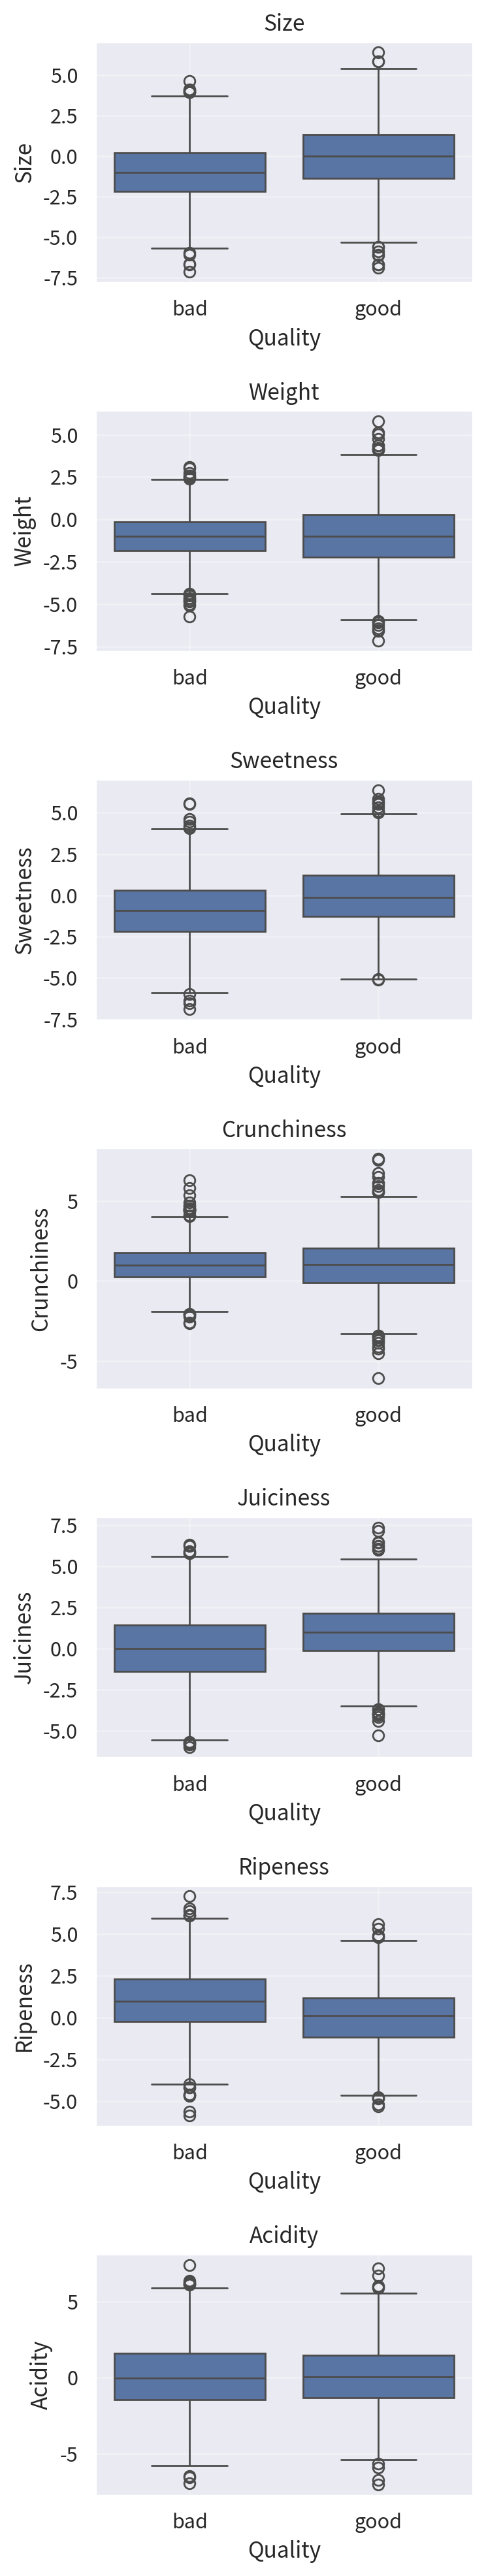

In [13]:
# 히스토그램으로 보고 싶은 컬럼 7개
cols_list = ["Size", "Weight", "Sweetness", "Crunchiness",
             "Juiciness", "Ripeness", "Acidity"]

# 1) 그래프 초기화
width_px = 800              # 그래프 가로 크기
height_px = 4000              # 그래프 세로 크기
rows = 7                     # 그래프 행 수 (컬럼 7개)
cols = 1                     # 그래프 열 수 (1열로 쭉)

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# ax가 1열이면 ax는 (7,) 형태라서 그대로 사용 가능
for i, col in enumerate(cols_list):
    sb.boxplot(
        data=origin_타입변환,
        x='Quality',
        y=col,
        orient="v",
        ax=ax[i]
    )
    ax[i].grid(alpha=0.3)
    ax[i].set_title(col)

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


### 5단계. 변수간 관계 탐색 - 변수들은 서로 독립적일까?
1. 연속형 변수들의 상관 계수를 계산하자
2. 상관 행렬을 히트맵으로 시각화하자
3. 상관이 높은 변수들을 동시에 사용할 떄의 문제점을 고민해보자
> 상관이 높은 데이터들을 동시에 사용하면 다중공선성 문제가 발생할 수 있다. 그렇게 되면 모델에 영향을 더 크게 미치는 항목을 정확하게 판단하기 어려워 진다

In [14]:


for i in cols_list:
  for v in cols_list:

    spearman_r, spearman_p = spearmanr(origin_타입변환[i], origin_타입변환[v])
    print(i,'와',v,'의 상관계수: ',"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p,  "대립" if spearman_p <= 0.05 else "귀무"))

Size 와 Size 의 상관계수:  statistic: 1.000, p-value: 0.000, 대립가설 채택
Size 와 Weight 의 상관계수:  statistic: -0.144, p-value: 0.000, 대립가설 채택
Size 와 Sweetness 의 상관계수:  statistic: -0.310, p-value: 0.000, 대립가설 채택
Size 와 Crunchiness 의 상관계수:  statistic: 0.172, p-value: 0.000, 대립가설 채택
Size 와 Juiciness 의 상관계수:  statistic: -0.032, p-value: 0.044, 대립가설 채택
Size 와 Ripeness 의 상관계수:  statistic: -0.155, p-value: 0.000, 대립가설 채택
Size 와 Acidity 의 상관계수:  statistic: 0.210, p-value: 0.000, 대립가설 채택
Weight 와 Size 의 상관계수:  statistic: -0.144, p-value: 0.000, 대립가설 채택
Weight 와 Weight 의 상관계수:  statistic: 1.000, p-value: 0.000, 대립가설 채택
Weight 와 Sweetness 의 상관계수:  statistic: -0.120, p-value: 0.000, 대립가설 채택
Weight 와 Crunchiness 의 상관계수:  statistic: -0.087, p-value: 0.000, 대립가설 채택
Weight 와 Juiciness 의 상관계수:  statistic: -0.091, p-value: 0.000, 대립가설 채택
Weight 와 Ripeness 의 상관계수:  statistic: -0.244, p-value: 0.000, 대립가설 채택
Weight 와 Acidity 의 상관계수:  statistic: 0.030, p-value: 0.054, 귀무가설 채택
Sweetness 와 Size 의 상관계수:  statistic: -0.310

In [15]:
corr_matrix = origin_타입변환[["Size", "Weight", "Sweetness", "Crunchiness",
             "Juiciness", "Ripeness", "Acidity"]].corr(method='spearman')
corr_matrix

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
Size,1.000000,-0.144268,-0.310476,0.171818,-0.031881,-0.154780,0.209998
Weight,-0.144268,1.000000,-0.119883,-0.087117,-0.090611,-0.244340,0.030479
Sweetness,-0.310476,-0.119883,1.000000,-0.017346,0.097540,-0.254604,0.072026
Crunchiness,0.171818,-0.087117,-0.017346,1.000000,-0.236538,-0.183677,0.073556
Juiciness,-0.031881,-0.090611,0.097540,-0.236538,1.000000,-0.124169,0.230778
Ripeness,-0.154780,-0.244340,-0.254604,-0.183677,-0.124169,1.000000,-0.194695
Acidity,0.209998,0.030479,0.072026,0.073556,0.230778,-0.194695,1.000000


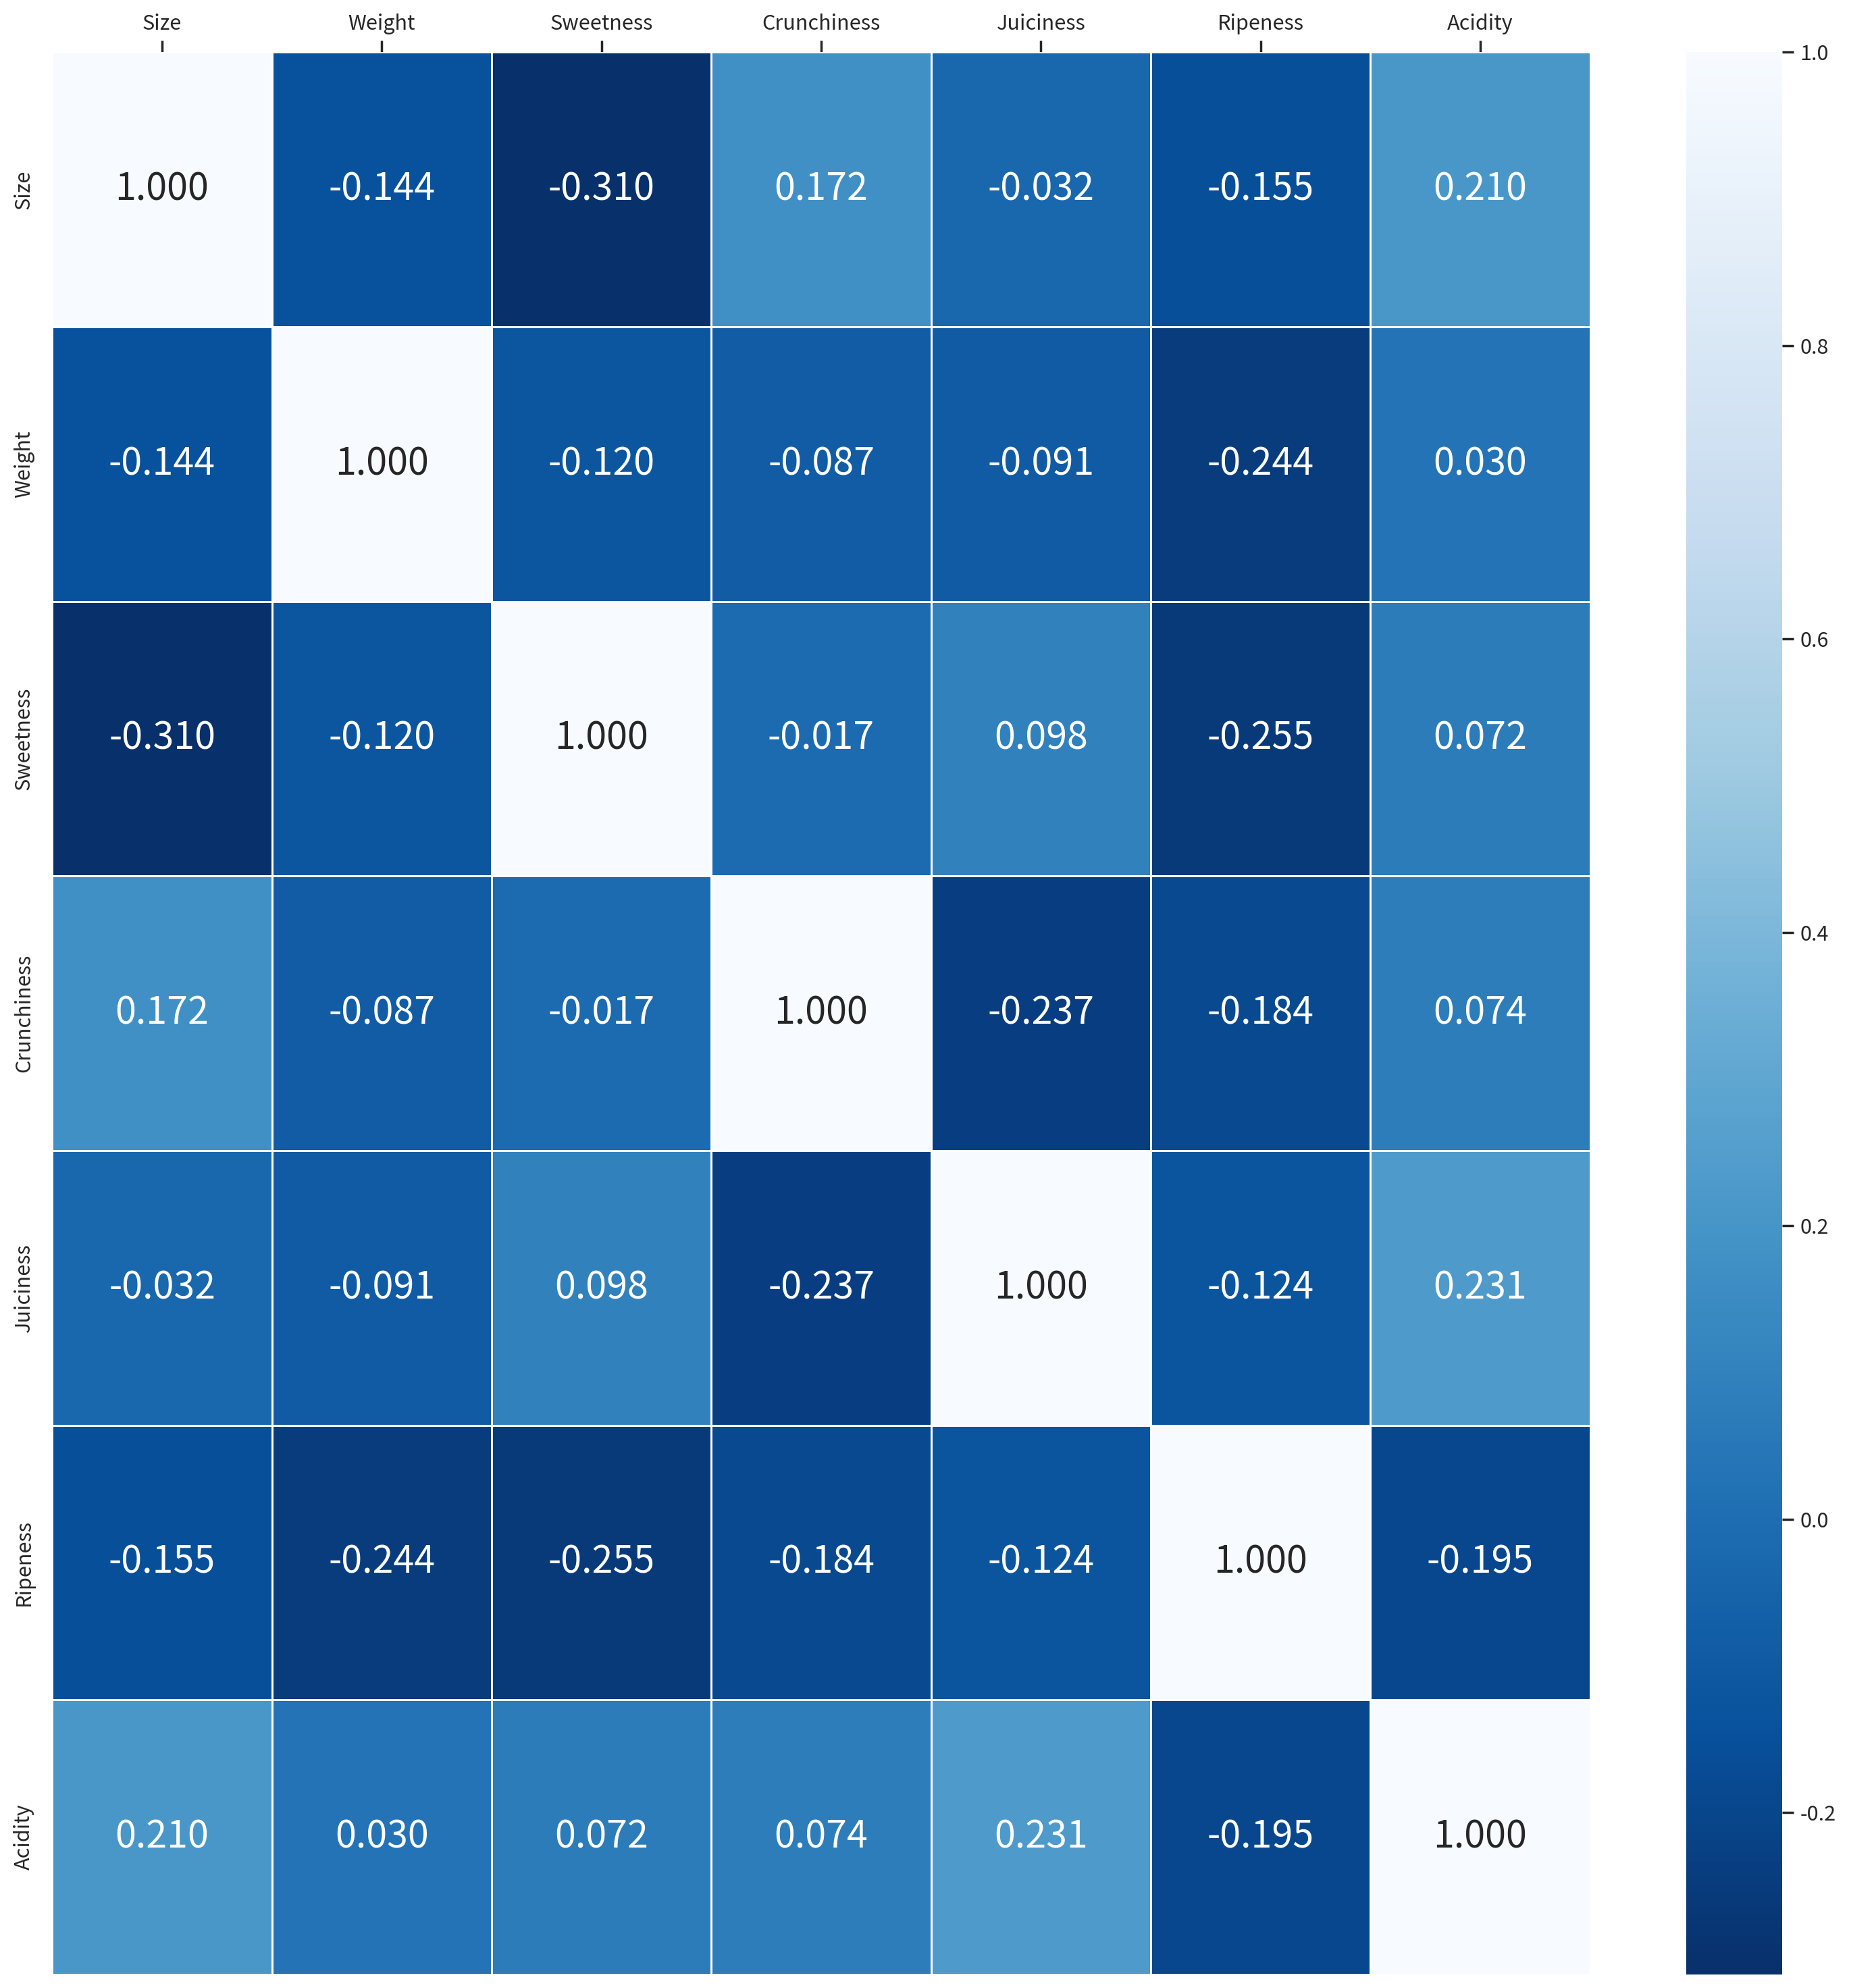

In [16]:
# 1) 그래프 초기화
width_px  = 3000          # 그래프 가로 크기
height_px = 3000         # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.3f",
    linewidth=0.5,
    cmap="Blues_r",
    annot_kws={"size": 20}
)

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()      # x축의 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()       # 여백 제거
plt.show()               # 그래프 화면 출력
plt.close()              # 그래프 작업 종료


### 6.단계 . EDA 를 바탕으로 한 모델 설계 : 그려본 결과를 어떻게 모델로 옮길까? 

1. 지금까지의 EDA 결과를 간단히 요약하자.
[EDA 결과 요약]

- 모든 연속형 변수(Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness, Acidity)는 대체로 정규분포에 가까운 형태를 보이며, 극단적인 이상치는 일부 존재하지만 분석에 큰 문제는 없다고 판단된다.

- Quality(bad/good)에 따른 박스플롯 비교 결과,
Size, Weight, Sweetness, Juiciness는 good 그룹에서 중앙값이 더 높은 경향을 보였다.

- 반면 Ripeness와 Acidity는 bad 그룹에서 상대적으로 값이 높은 경향을 보여,
품질과 음의 관계가 있을 것으로 예상되었다.

- Crunchiness는 두 그룹 간 분포 차이가 크지 않아 품질을 설명하는 데 기여도가 낮을 가능성이 관찰되었다.

- 변수 간 Spearman 상관계수는 전반적으로 낮아, 다중공선성 문제는 크지 않을 것으로 판단된다.


1. 사용할 독립변수를 최종 선정하자.
- 최종 선택 변수
Size
Weight
Sweetness
Juiciness
Ripeness
Acidity

   제외 변수
Crunchiness

1. 각 변수 선택에 대해 다음 문장을 완성하자.
🔹 Size

이 변수는 EDA 단계에서 good 품질 사과의 중앙값이 bad 품질보다 높게 나타나는 패턴을 보였기 때문에 품질을 설명하는 데 도움이 될 것으로 판단했다.

🔹 Weight

이 변수는 Quality에 따라 분포의 위치 차이가 관찰되었으며, good 품질 사과에서 상대적으로 큰 값을 보이는 경향이 있어 품질 설명 변수로 적합하다고 판단했다.

🔹 Sweetness

이 변수는 EDA 단계에서 good 그룹에서 전반적으로 높은 분포를 보였고, 품질과 양의 관계가 있을 것으로 예상되어 중요한 설명 변수로 선정했다.

🔹 Juiciness

이 변수는 good 품질 사과에서 중앙값과 상위 분포가 더 높게 나타나는 패턴을 보여, 품질을 구분하는 데 유용할 것으로 판단했다.

🔹 Ripeness

이 변수는 EDA에서 bad 품질 사과의 값이 상대적으로 높게 나타나 과숙이 품질 저하와 관련될 가능성이 관찰되어 설명 변수로 포함했다.

🔹 Acidity

이 변수는 bad 그룹에서 높은 값을 보이는 경향이 뚜렷하게 나타나, 품질과 음의 관계를 설명하는 데 도움이 될 것으로 판단했다.

❌ Crunchiness 

Crunchiness는 EDA 단계에서 Quality에 따른 분포 차이가 크지 않았으며, 로지스틱 회귀에서도 통계적으로 유의하지 않아 최종 독립변수에서 제외하였다.

[요약]

EDA 결과를 바탕으로 Size, Weight, Sweetness, Juiciness는 품질과 양의 관계를, Ripeness와 Acidity는 음의 관계를 가질 것으로 판단되어 최종 독립변수로 선정하였으며, Crunchiness는 품질 구분력이 낮아 제외하였다.

### 7.단계 로지스틱 회쉬 모델 적합
- 로지스틱 회귀 모델을 적합하자.
- 회귀계수의 부호와 크기를 확인하자.
- EDA에서 예상한 방향과 결과가 일치하는지 비교하자.
  
<회귀계수의 부호와 크기 확인>

- Size, Weight, Sweetness, Juiciness는 양(+)의 회귀계수를 가져, 값이 증가할수록 품질이 좋을 확률이 증가하는 것으로 나타났다.
특히 Size(0.6495)와 Sweetness(0.5688)는 상대적으로 큰 계수를 보여 품질에 미치는 영향이 큰 변수로 해석된다.

- Acidity(-0.2941)와 Ripeness(-0.1267)는 음(−)의 회귀계수를 보여, 값이 높아질수록 품질이 나빠질 확률이 증가하는 경향을 보였다.

- Crunchiness(0.0346)는 계수의 크기가 매우 작고 통계적으로 유의하지 않아, 품질 설명력은 제한적인 것으로 판단된다.

<EDA 결과와의 비교>

EDA 단계에서 good 품질 사과는 Size, Weight, Sweetness, Juiciness가 상대적으로 높고,
Ripeness와 Acidity는 낮을 것으로 예상하였다.

로지스틱 회귀 분석 결과, 해당 변수들의 회귀계수 부호가 EDA에서 예상한 방향과 일치하였으며,
Crunchiness는 EDA에서 관찰된 바와 같이 품질 구분에 미치는 영향이 크지 않은 것으로 확인되었다.

따라서 본 로지스틱 회귀 모델의 결과는 EDA 단계에서의 가설을 전반적으로 지지하는 것으로 판단된다.

In [17]:
df_model = origin_타입변환.copy()
df_model['Quality'] = df_model['Quality'].map({'bad': 0, 'good': 1})

df_model.head()


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


#### 로지스틱 수행

In [18]:
yname = 'Quality'    #종속변수 이름


x=df_model.drop([yname,'A_id'],axis=1)   # 독립변수만 추출
y=df_model[yname]


x_input=sm.add_constant(x)
display(x_input)



fit=sm.Logit(y,x_input).fit()
tbl1=fit.summary()
print(tbl1)


,const,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,1.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809
2,1.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636
3,1.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723
4,1.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984
...,...,...,...,...,...,...,...,...
3995,1.0,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784
3996,1.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235
3997,1.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611
3998,1.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720


Optimization terminated successfully.
         Current function value: 0.514195
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Quality   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3992
Method:                           MLE   Df Model:                            7
Date:                Tue, 23 Dec 2025   Pseudo R-squ.:                  0.2582
Time:                        15:07:42   Log-Likelihood:                -2056.8
converged:                       True   LL-Null:                       -2772.6
Covariance Type:            nonrobust   LLR p-value:                5.599e-305
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6462      0.061     10.514      0.000       0.526       0.767
Size            0.6495    

### 8단계 . 오즈비를 통한 해석 - 숫자를 다시 사람의 언어로

1. 회귀계수를 오즈비로 변환하자.
2. 주요 변수 2~3개를 골라 해석 문장을 작성하자.
3. 이 해석이 EDA 결과와 어떻게 연결되는지 설명하자.



| 변수          |  오즈비 (OR) | 해석                                                | 영향 강도     |
| ----------- | --------: | ------------------------------------------------- | --------- |
| const       |     1.908 | 모든 설명변수가 0일 때의 기준 오즈로, 실질적인 해석 대상은 아님             | 기준값       |
| Size        | **1.915** | Size가 1단위 증가할 때 사과가 Good일 오즈가 약 **1.92배 증가**      | 강함        |
| Weight      | **1.306** | Weight가 1단위 증가할 때 Good일 오즈가 약 **1.31배 증가**        | 보통        |
| Sweetness   | **1.766** | Sweetness가 1단위 증가할 때 Good일 오즈가 약 **1.77배 증가**     | 강함        |
| Crunchiness |     1.035 | Crunchiness가 1단위 증가할 때 오즈가 약 **3.5% 증가**하나 영향은 미미 | 매우 약함     |
| Juiciness   | **1.556** | Juiciness가 1단위 증가할 때 Good일 오즈가 약 **1.56배 증가**     | 보통~강함     |
| Ripeness    | **0.881** | Ripeness가 1단위 증가할 때 Good일 오즈가 약 **12% 감소**        | 보통(음의 영향) |
| Acidity     | **0.745** | Acidity가 1단위 증가할 때 Good일 오즈가 약 **25% 감소**         | 강함(음의 영향) |



[주요 변수 3개 해석 문장]
- (1) Size
Size의 오즈비는 약 1.92로, Size가 1단위 증가할 때 사과가 Good 품질일 오즈가 약 1.9배 증가하는 것으로 해석된다.

- (2) Sweetness
Sweetness의 오즈비는 약 1.77로, 당도가 1단위 증가할 경우 사과가 Good 품질일 오즈가 약 77% 증가하는 것으로 나타났다.

- (3) Acidity
Acidity의 오즈비는 약 0.75로, 산도가 1단위 증가할 때 Good 품질일 오즈가 약 25% 감소하는 음의 영향을 미치는 변수로 해석된다.



[오즈비 해석과 EDA 결과의 연결]

EDA 단계에서 박스플롯 분석 결과,
Size와 Sweetness는 good 품질 사과에서 중앙값이 더 높게 나타났고,

Acidity는 bad 품질 사과에서 상대적으로 높은 분포를 보였다.

이러한 분포 차이는 로지스틱 회귀에서
Size와 Sweetness의 오즈비가 1보다 크게 추정되고,
Acidity의 오즈비가 1보다 작게 추정된 결과와 일관된다.

즉, EDA에서 관찰된 변수별 분포 패턴이 로지스틱 회귀 모델의 오즈비 해석을 통해 정량적으로 재확인되었다고 볼 수 있다.


> 오즈비가 약 8.92로 나타나,실제 Positive(예: Good 품질)인 경우를 모델이 Positive로 예측할 오즈가
Negative인 경우에 비해 약 8.9배 높다고 해석할 수 있다.이는 본 로지스틱 회귀 모델이 Positive 클래스(품질이 좋은 사과)를 구분하는 데 비교적 강한 판별력을 가지고 있음을 의미한다.

### 혼동행렬을 구해보자! 

#### 종속변수를 구한다

In [19]:
y_true = df_model['Quality']
y_true

0       1
1       1
2       0
3       1
4       1
       ..
3995    0
3996    1
3997    0
3998    1
3999    1
Name: Quality, Length: 4000, dtype: category
Categories (2, int64): [0, 1]

#### 로지스틱이 예측한 값

In [20]:
y_pred = fit.predict(x_input)
y_pred

0       0.789560
1       0.849622
2       0.397615
3       0.897764
4       0.909410
          ...   
3995    0.219191
3996    0.608487
3997    0.096303
3998    0.620595
3999    0.642597
Length: 4000, dtype: float64

#### - 혼동행렬 구하기 위해 예측 결과를 이진값으로 변환
  50% 초과인 경우 True , 그렇지 않을 경우 False 로 변환

In [21]:
y_pred_fix = y_pred >0.5
y_pred_fix

0        True
1        True
2       False
3        True
4        True
        ...  
3995    False
3996     True
3997    False
3998     True
3999     True
Length: 4000, dtype: bool

#### 혼동행렬

In [22]:
cm = confusion_matrix(y_true , y_pred_fix)
tn , fp , fn , tp = cm.ravel()
tn , fp, fn , tp

(np.int64(1460), np.int64(536), np.int64(469), np.int64(1535))

#### 혼동행렬을 dataframe 으로 변환

In [23]:
cmdf = DataFrame (cm,index =['Actual 0 (TN/FP)' , 'Actual 1 (FN/TP)'] , columns = ['Predicted (Negative)' , 'Predicted (Positice)'])


cmdf

,Predicted (Negative),Predicted (Positice)
Actual 0 (TN/FP),1460,536
Actual 1 (FN/TP),469,1535


#### 정확도 구하기

In [24]:
acc=accuracy_score(y_true , y_pred_fix)
acc

0.74875

#### 정밀도 구하기

In [25]:
#PRE = TP / (FP+TP)
pre = precision_score(y_true,y_pred_fix)
pre

0.7411878319652342

#### 재현율 구하기

In [26]:
recall = tp/(tp+fn)
recall = recall_score(y_true, y_pred_fix)
recall

0.7659680638722555

#### 위양성율 구하기

In [27]:
fpr = fp / (fp+tn)

fpr

np.float64(0.2685370741482966)

#### 특이성 구하기

In [28]:
tnr = 1-fpr
tnr

np.float64(0.7314629258517034)

#### f1 score 구하기

In [29]:
#f1 = 2*((pre*Recall)) / (pre+recall)
f1 = f1_score(y_true, y_pred_fix)
f1

0.7533742331288343

#### 오즈비 구하기
- 계수 추출

In [30]:
coef = fit.params
coef

const          0.646219
Size           0.649469
Weight         0.266729
Sweetness      0.568788
Crunchiness    0.034581
Juiciness      0.442237
Ripeness      -0.126745
Acidity       -0.294117
dtype: float64

- 오즈 구하기

In [31]:
odds_rate = np.exp(coef)
odds_rate_df = DataFrame(odds_rate , columns =['odds_rate'])
odds_rate_df

,odds_rate
const,1.908312
Size,1.914524
Weight,1.305687
Sweetness,1.766126
Crunchiness,1.035186
Juiciness,1.556184
Ripeness,0.880959
Acidity,0.745190


In [32]:
odds_ratio = (tp*tn) / (fp*fn)
odds_ratio


np.float64(8.915046303662923)

> 오즈비가 약 8.92로 나타나,실제 Positive(예: Good 품질)인 경우를 모델이 Positive로 예측할 오즈가
Negative인 경우에 비해 약 8.9배 높다고 해석할 수 있다.

이는 본 로지스틱 회귀 모델이 Positive 클래스(품질이 좋은 사과)를 구분하는 데 비교적 강한 판별력을 가지고 있음을 의미한다.

### 9단계. 시각화로 보는 모델 성능 > 모델은 어떤 판단을 하고 있을까?

1. 혼동행렬을 시각화하자.
   - True Negative (TN): 1460 (실제 Negative를 Negative로 정확히 예측)
   - False Positive (FP): 536 (실제 Negative를 Positive로 잘못 예측)
   - False Negative (FN): 469 (실제 Positive를 Negative로 잘못 예측)
   - True Positive (TP): 1535 (실제 Positive를 Positive로 정확히 예측)
  
2. ROC Curve를 그리고 AUC를 계산하자.
   - AUC 0.7487: 일반적으로 AUC가 0.5이면 무작위 예측과 같고, 1.0이면 완벽한 분류기를 의미합니다. 현재 도출된 0.75 수준의 점수는 모델이 '어느 정도 유의미한 예측 성능을 가지고 있음을 나타냅니다.
  
3. ROC Curve의 모양을 말로 설명하자.
   - 가파른 초기 상승 확인: 그래프는 좌측 하단에서 시작하여 초기 구간에서 비교적 가파르게 상승합니다. 

   - 변곡점 존재: 그래프가 꺾이는 지점은 대략 x축(FPR) 0.27, y축(TPR) 0.78 부근에 위치해 있습니다. 이 지점이 모델이 가장 효율적으로 작동하는 임계값(Threshold)일 가능성이 높습니다.

   - 완만한 후반부: 변곡점을 지난 이후에는 기울기가 완만해지며 우측 상단을 향해 직선에 가깝게 증가합니다.

   - 점선과의 거리: 붉은 점선보다 확연히 위쪽(좌측 상단)으로 부풀어 오른 형태를 띠고 있어, 모델이 학습을 통해 유의미한 분류 능력을 갖추었음을 시각적으로 보여줍니다. 다만, 좌측 상단 모서리에 아주 가까이 붙은 형태('ㄱ'자 모양)는 아니므로 고성능 모델로 가기 위한 개선의 여지가 남아 있습니다.


#### 혼동행렬 히트맵

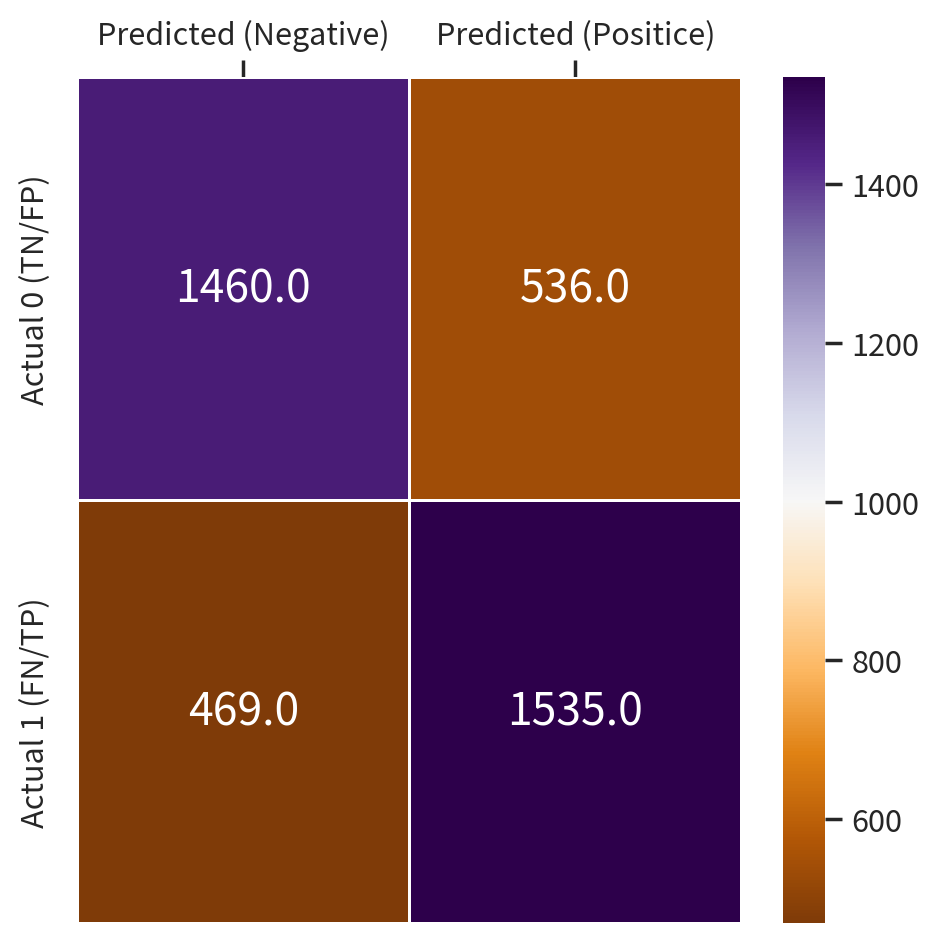

In [33]:
# 1) 그래프 초기화
width_px  = 1000   # 그래프 가로 크기
height_px = 1000   # 그래프 세로 크기
rows = 1          # 그래프 행 수
cols = 1          # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=cmdf,
    annot=True,
    fmt="0.1f",
    linewidth=0.5,
    cmap="PuOr"
)

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()   # x축의 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()    # 여백 제거
plt.show()            # 그래프 화면 출력
plt.close()           # 그래프 작업 종료


#### ROC Curve

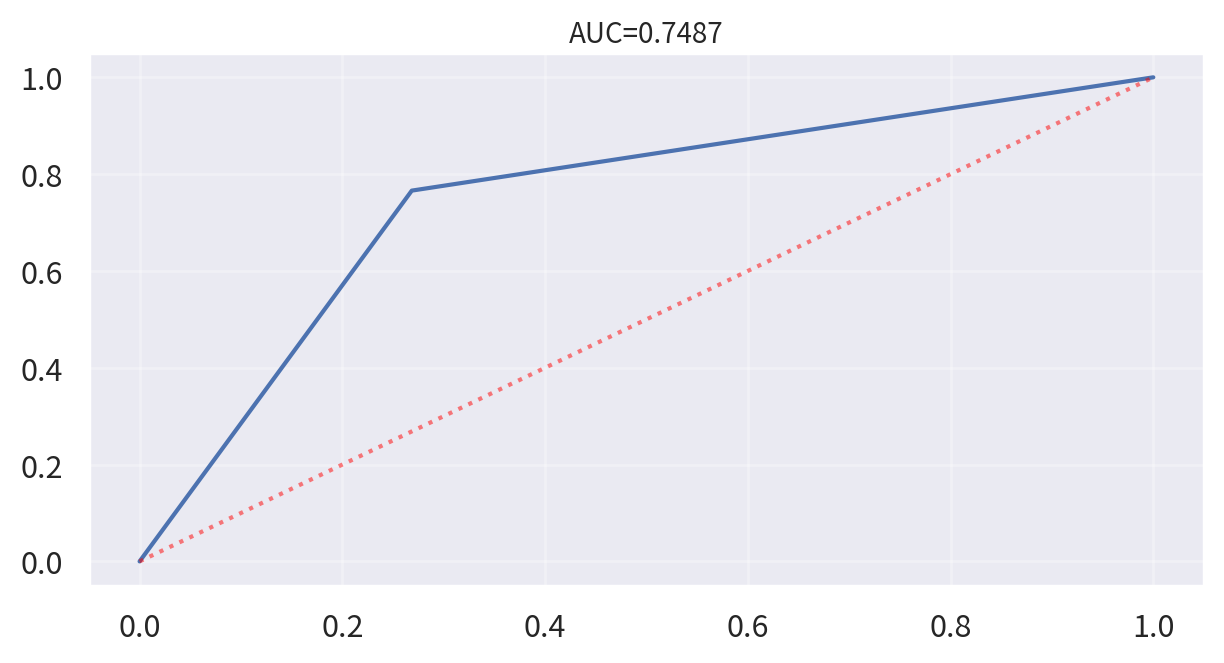

In [34]:
ras = roc_auc_score(y_true, y_pred_fix)
0

roc_fpr , roc_tpr ,thresholds = roc_curve(y_true, y_pred_fix)


# 1) 그래프 초기화
width_px = 1280          # 그래프 가로 크기
height_px = 720          # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LinePlot 그리기
sb.lineplot(x=roc_fpr, y=roc_tpr)
sb.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle=':', alpha=0.5)

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)          # 배경 격자 표시
ax.set_title(f'AUC={ras:.4f}', fontsize=10, pad=4)

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


> AUC 는 0.75 로 확인되었다

In [35]:
result_df = DataFrame({
    '설명력(Pseudo-Rsq)': [fit.prsquared],
    '정확도(Accuracy)': [acc],
    '정밀도(Precision)': [pre],
    '재현율(Recall, TPR)': [recall],
    '위양성율(Fallout, FPR)': [fpr],
    '특이성(Specificity, TNR)': [tnr],
    'RAS': [ras],
    'f1_score': [f1]
})

result_df


,설명력(Pseudo-Rsq),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.258172,0.74875,0.741188,0.765968,0.268537,0.731463,0.748715,0.753374


### 10단계. 같은 조건, 다른 판단 = 모델은 어디서 갈림길을 만들었을까?
1. 가상의 사과 2개를 설정하자
   - 당도가 높고 산도가 낮은 사과 A 와 당도는 낮고 산도가 높은 사과 B 데이터를 가정했습니다
  
2. 예측 확률이 달라진 이유를 분석하자
   - 사과 A: Sweetness(+4.5)가 큰 양수 계수와 곱해져 점수를 대폭 올렸고, Acidity(-0.5)가 낮아 감점이 적었습니다. 
   - 사과 B: Sweetness(-2.0)가 낮아 점수를 깎아먹었고, Acidity(+3.0)가 높아 큰 음수 계수와 곱해져 점수가 대폭 깎였습니다. 
  
3. EDA > 회귀계수 > 확률의 흐름을 설명하자
   <EDA>
   - EDA (탐색적 데이터 분석) 과정에서, Boxplot 을 그려봄으로써 Sweetness 가 높을수로 good에 속할 가능성이 높은 것을 관찰하였고, 당도를 플러스 요인, 산도는 마이너스 요인이라 추측할 수 있었습니다
  
   <회귀계수>
   - 모델의 회귀계수는 우리의 직관을 수치적으로 확정 지었습니다. 분석 결과가 이를 증명합니다.
   - 크기(Size): 계수 +0.65 (오즈비 약 1.91배)  
   - 당도(Sweetness): 계수 +0.57 (오즈비 약 1.77배) 
   - 산도(Acidity): 음수(-) 계수 
  
   - 이 규칙에 따라 모델은 가상의 사과들을 채점합니다.
   - 사과 A: 당도(+4.5) 계수(+0.57) = 폭발적인 가산점 (+)
   - B: 당도(-2.0)  계수(+0.57) = 치명적인 감점 (-)
   
   <확률>
   - 마지막으로, 모델은 계산된 점수(Logit)를 시그모이드 함수에 통과시켜 0과 1 사이의 확률로 변환합니다.

  - 판단 결과:

    점수를 많이 번 사과 A는 확률 그래프의 오른쪽 끝으로 밀려가 99.9%(Good)라는 확신을 얻습니다.

    점수를 잃은 사과 B는 왼쪽 끝으로 떨어져 0.1%(Bad)라는 평가를 받게 됩니다.


    > EDA에서 발견한 '크고 달콤함'이라는 패턴을, 모델은 '양수(+)의 회귀계수'로 학습했고, 이를 통해 프리미엄 사과에는 '높은 확률'을 부여하여 인간의 직관과 동일한 판단을 내렸습니다.

<가상의 사과 데이터>

In [37]:
import pandas as pd

# 가상의 사과 데이터 2개 정의 (프리미엄 꿀사과 vs 덜 익은 풋사과)
data = [
    [4000, 2.5, 1.5, 4.5, 1.5, 2.6, 1.08, -0.5, 'good'],
    [4001, -1.2, 1.5, -2.0, 0.5, 0.26, 3.08, 3.0, 'bad']
]

# 컬럼명 정의
columns = ['A_id', 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity', 'Quality']

# 데이터프레임 생성
df_virtual = pd.DataFrame(data, columns=columns)

# 결과 확인
print(df_virtual)

   A_id  Size  Weight  Sweetness  Crunchiness  Juiciness  Ripeness  Acidity  \
0  4000   2.5     1.5        4.5          1.5       2.60      1.08     -0.5   
1  4001  -1.2     1.5       -2.0          0.5       0.26      3.08      3.0   

  Quality  
0    good  
1     bad  


In [ ]:
# 1. 예측에 불필요한 컬럼 제거 
# A_id와 Quality는 특성(Feature)이 아니므로 제거
X_virtual = df_virtual.drop(['A_id', 'Quality'], axis=1)

# 2. 상수항(const) 추가
X_virtual = sm.add_constant(X_virtual, has_constant='add')

# 3. 예측 수행 
pred_probs = fit.predict(X_virtual)

# 4. 결과 출력
print("=== 가상의 사과 2개에 대한 'Good' 확률 예측 ===")
print(f" 사과 A 4000(프리미엄): {pred_probs[0]*100:.2f}%")
print(f" 사과 B 4001 (풋사과)  : {pred_probs[1]*100:.2f}%")

# 전체 데이터 확인
print("\n--- 전체 데이터 및 확률 ---")
result_view = X_virtual.copy()
result_view['Predicted_Prob_Good'] = pred_probs
display(result_view)

=== 가상의 사과 2개에 대한 'Good' 확률 예측 ===
 사과 A 4000(프리미엄): 99.84%
 사과 B 4001 (풋사과)  : 11.80%

--- 전체 데이터 및 확률 ---


,const,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Predicted_Prob_Good
0,1.0,2.5,1.5,4.5,1.5,2.60,1.08,-0.5,0.998408
1,1.0,-1.2,1.5,-2.0,0.5,0.26,3.08,3.0,0.118045
